In [27]:
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U datasets scipy ipywidgets matplotlib
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/peft.git

In [28]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [29]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,2,3,4,5,6,7"

In [30]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=False, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=False, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [31]:
accelerator.process_index

0

In [33]:
import torch

In [34]:
from datasets import load_dataset

train_dataset = load_dataset("/scratch/vetgpt/data/finetune/clean_short10",split='train')
eval_dataset = load_dataset("/scratch/vetgpt/data/finetune/clean_short10",split='validation')
test_dataset = load_dataset('/scratch/vetgpt/data/finetune/clean_short10', split='test')

In [35]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
base_model_id = "azsxscdvfb/vetmedgpt-1B-V0.1"
model = AutoModelForCausalLM.from_pretrained(base_model_id,  device_map="cuda")

model = accelerator.prepare_model(model)

if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [36]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True, 
)

In [37]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

In [38]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""You are an veterinarian and you are consulting a client, you should answer their question and provide them with the best advice.

### Question:
{data_point["Question"]}

### Answer:
{data_point['Answer']}
"""
    return tokenize(full_prompt)

In [39]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

In [40]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids']) 
print(untokenized_text)

<s> You are an veterinarian and you are consulting a client, you should answer their question and provide them with the best advice.

### Question:
What is the most common allergic reaction to cats?

### Answer:
Swollen, red, itchy, and watery eyes (allergic conjunctivitis); nasal congestion, itchy nose, sneezing (allergic rhinitis or "hay fever"); ear pain similar to pain caused by an ear infection; sore throat or itchy throat; coughing and wheezing; hives or rash on the face or chest; and itchy skin.
</s>


33392


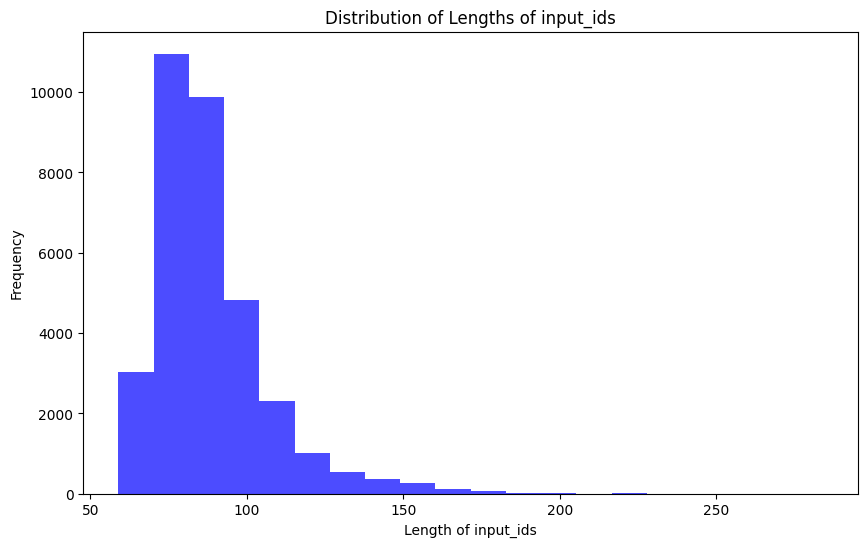

In [41]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [42]:
max_length = 512 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,  
    add_bos_token=True,  
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [43]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

In [44]:
print(tokenized_train_dataset[4]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [45]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids']) 
print(untokenized_text)

</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>

In [46]:
import transformers
from datetime import datetime

project = "vetmedgpt-finetune"
base_model_name = "vetmedgpt-1B"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        num_train_epochs=5,
        learning_rate=2.5e-5,
        logging_steps=50,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=500,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=500,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="tensorboard",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/scratch/vetgpt/miniconda3/envs/test/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.720300,0.787133
1000,0.495100,0.646050
1500,0.452800,0.561474
2000,0.390600,0.528463
2500,0.308900,0.505630
3000,0.285300,0.478898
3500,0.238900,0.481564
4000,0.159300,0.504953
4500,0.161600,0.497275
5000,0.150000,0.503702


/scratch/vetgpt/miniconda3/envs/test/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/vetgpt/miniconda3/envs/test/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/vetgpt/miniconda3/envs/test/lib

TrainOutput(global_step=18550, training_loss=0.19252011787537937, metrics={'train_runtime': 9485.85, 'train_samples_per_second': 15.645, 'train_steps_per_second': 1.956, 'total_flos': 4.278675352584192e+17, 'train_loss': 0.19252011787537937, 'epoch': 5.0})

In [47]:
print("FSDP Configured with:")
print("State dict config:", fsdp_plugin.state_dict_config)
print("Optim state dict config:", fsdp_plugin.optim_state_dict_config)
print("Accelerator state:", accelerator.state)

FSDP Configured with:
State dict config: FullStateDictConfig(offload_to_cpu=False, rank0_only=False)
Optim state dict config: FullOptimStateDictConfig(offload_to_cpu=False, rank0_only=False)
Accelerator state: Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

